In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 495.5 kB/s eta 0:03:22
   ---------------------------------------- 0.2/99.8 MB 1.3 MB/s eta 0:01:16
   ---------------------------------------- 0.4/99.8 MB 2.8 MB/s eta 0:00:37
   ---------------------------------------- 0.7/99.8 MB 3.6 MB/s eta 0:00:28
   ---------------------------------------- 0.9/99.8 MB 4.2 MB/s eta 0:00:24
   ---------------------------------------- 1.0/99.8 MB 3.4 MB/s eta 0:00:29
    --------------------------------------- 1.7/99.8 MB 5.1 MB/s eta 0:00:20
    --------------------------------------- 2.0/99.8 MB 5.2 MB/s eta 0:00:19
    ---------------------------------

In [48]:
!pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [17]:
df = pd.read_csv(r"C:\Users\Vishwas\Desktop\Projects\time_series_forecasting\time_series_forecasting\data\PJME_hourly.csv")

In [18]:
df = df.set_index("Datetime")

In [19]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [20]:
df.dtypes

PJME_MW    float64
dtype: object

In [23]:
df.index = pd.to_datetime(df.index)

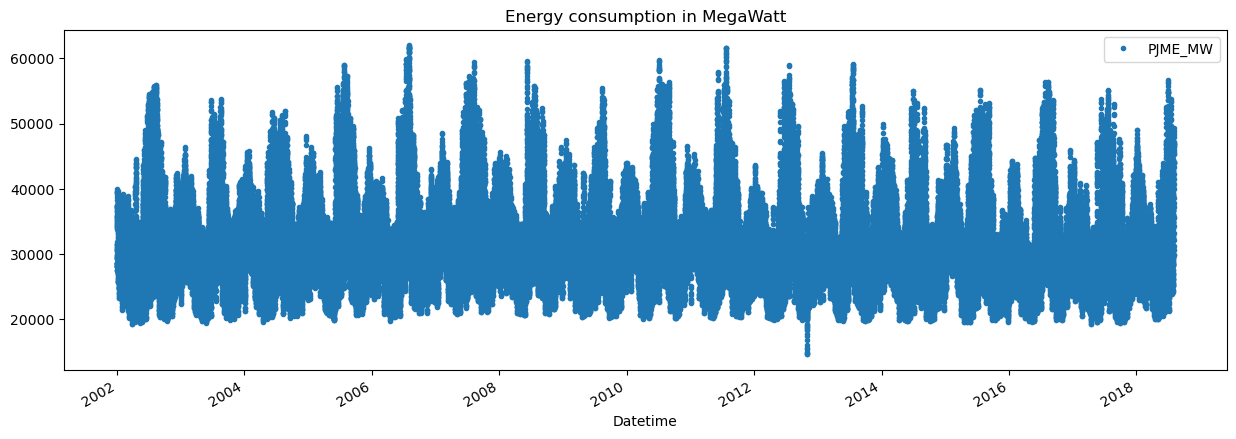

In [28]:
df.plot(style = ".", figsize = (15,5), title="Energy consumption in MegaWatt")
plt.show()

In [34]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [35]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


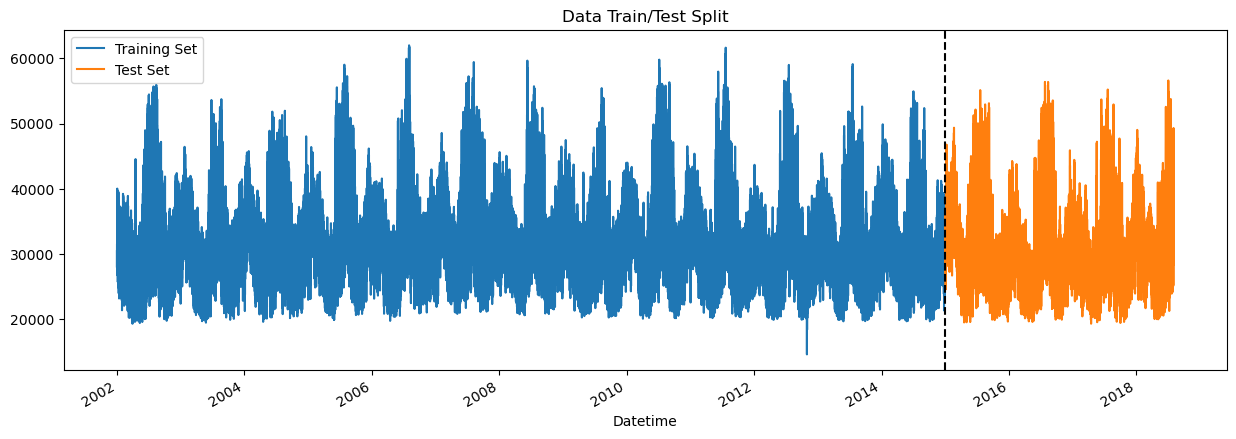

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Feature creation

In [40]:
def create_features(df):
    """
    Using index as base, get day, month, hour etc
    dayofweek is monday 0 and sunday is 6
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    
    return df

In [41]:
df = create_features(df)

In [42]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


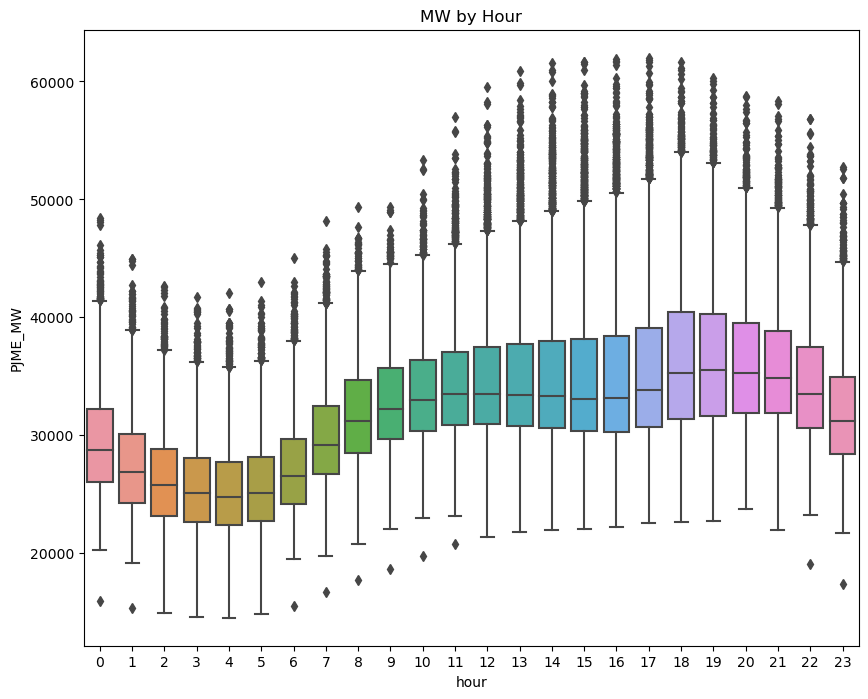

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

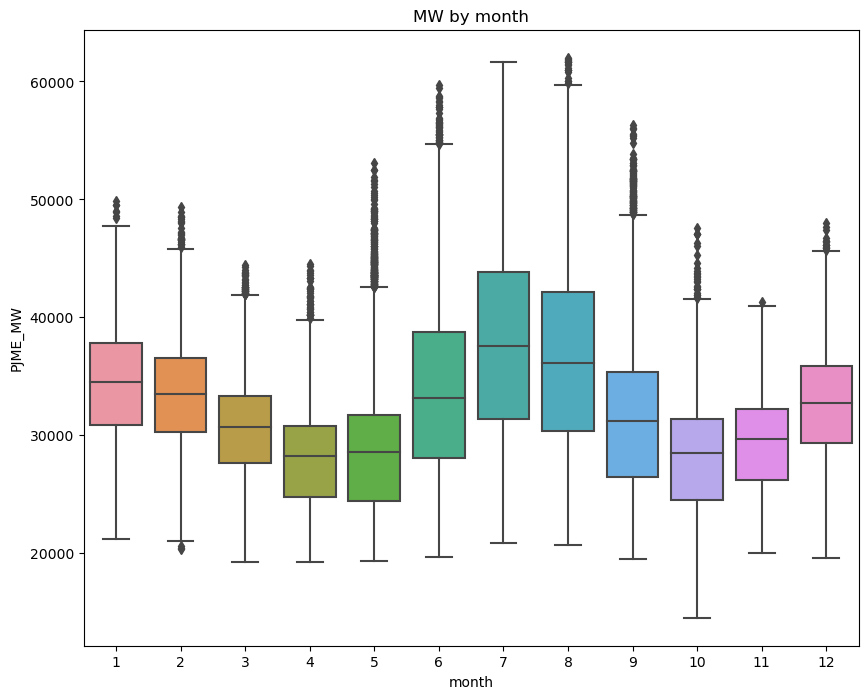

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by month')
plt.show()

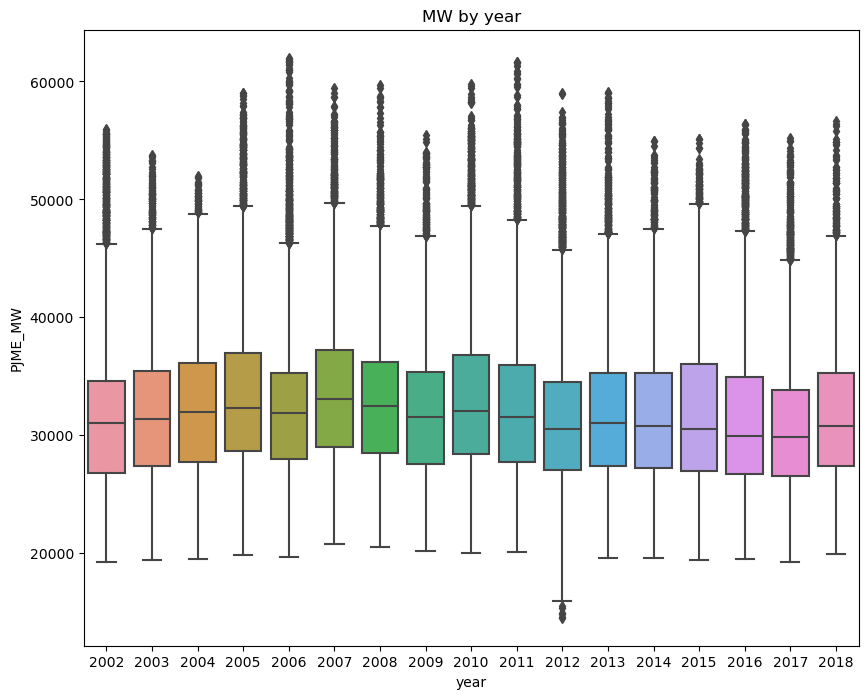

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='PJME_MW')
ax.set_title('MW by year')
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error

## regression model

In [54]:
train = create_features(train)
test = create_features(test)

In [55]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


In [56]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [59]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\Vishwas\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [60]:
reg.feature_importances_

array([0.13809589, 0.34923965, 0.1818622 , 0.05740253, 0.24737705,
       0.02602268], dtype=float32)

In [65]:
pd.DataFrame(reg.feature_importances_, index = reg.feature_names_in_, columns=['Important'])

,Important
dayofyear,0.138096
hour,0.349240
dayofweek,0.181862
quarter,0.057403
month,0.247377
year,0.026023


In [71]:
test['prediction'] = reg.predict(X_test)

In [72]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30422.880859
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28121.423828
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27169.205078
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,26777.427734
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,26777.427734
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,37738.308594
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,37685.746094
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,36207.367188


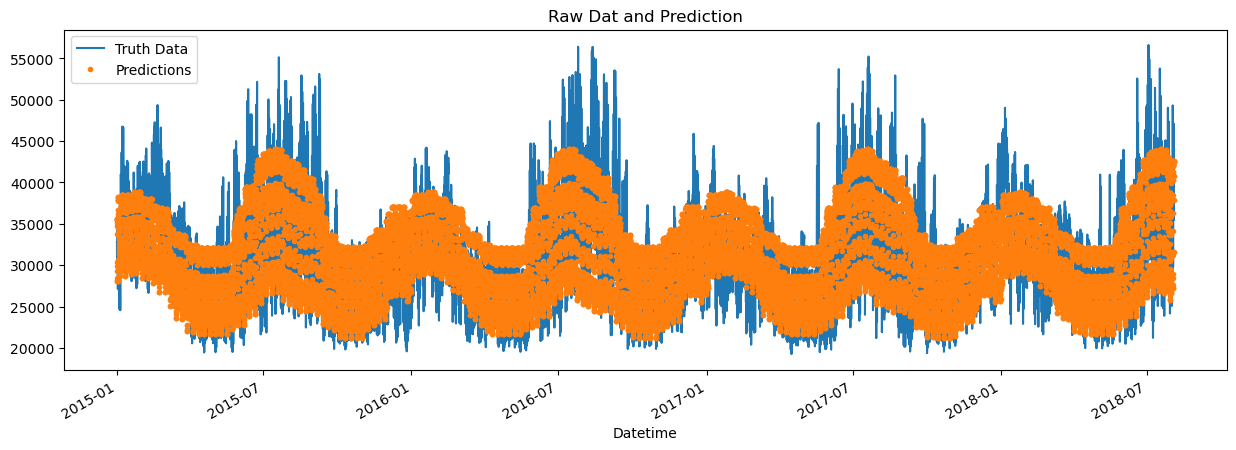

In [73]:
ax = test[['PJME_MW']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Visualise prediction for one week 

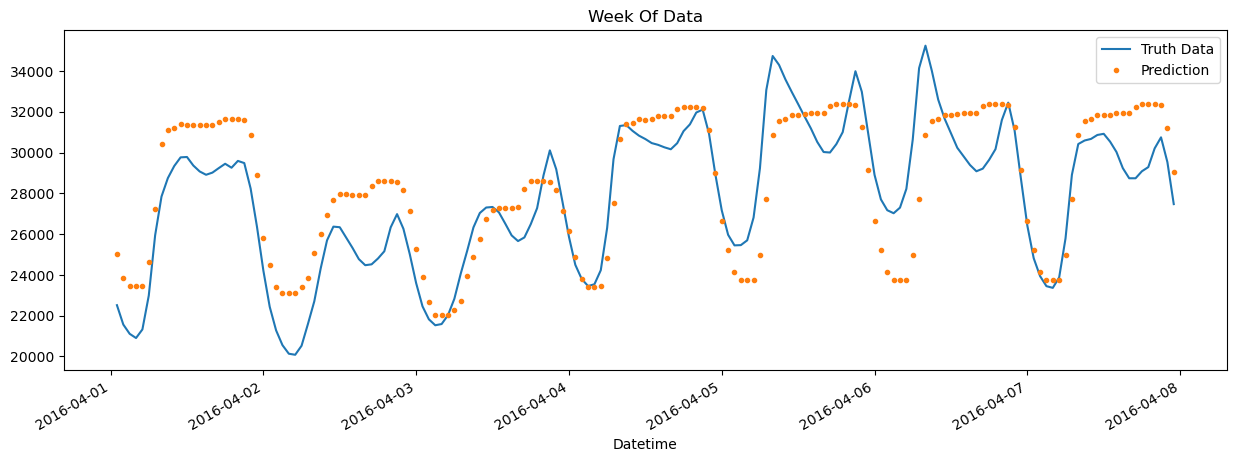

In [76]:
ax = test.loc[(test.index > '04-01-2016') & (test.index < '04-08-2016')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
test.loc[(test.index > '04-01-2016') & (test.index < '04-08-2016')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [78]:
np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))

3726.7985806757774